![](./img/dog.png)

Здравствуйте, дорогие хабровчане. Я Давно уже хотел изучить результаты программы bug bount Яндекса. Вот, наконец руки дошли. В этой простой и небольшой статье я рассмотрел её результаты, нашёл некоторые закономерости и вывел топ хантеров. Если кому интересно, в каком квартале года больше всего ошибок, или сколько багов выискал самый результативный хантер, прошу под кат.

In [1]:
import numpy as np
import pandas as pd
from scrapy.selector import Selector
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches 
import seaborn as sns
import requests
import time

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

sns.set(rc={'figure.figsize':(20, 5)})

In [9]:
# Запусти парсер, если нужна более акутальная информация

data_list = []

for year in range(2014, 2024 + 1):
    for month in range(1, 12 + 1):

        # Ограничение на начало
        if year == 2014 and month < 11:
            continue

        # Ограничение на конец
        if year == 2024 and month > 3:
            continue

        date = f"{year}.{month:0>2}"
        url = f"https://yandex.ru/bugbounty/hof/{year}/{month}/"

        try:
            response = requests.get(url)
            response.raise_for_status()
        except Exception as e:
            print("{} {:>41} \t{}".format(date, url, e))
            continue

        selector = Selector(text=response.text)
        table = selector.xpath('//div[@class="user user_S"]')

        temp_list = []
        for row in table:
            temp_list.append(
                {
                    "date": date,
                    "year": year,
                    "month": month, 
                    "account_link": row.xpath('*//@href').extract_first(),
                    "name": row.xpath('*//span/text()').extract_first(),
                    "avatar_link": row.xpath('*//@style').extract_first(),
                }
            )
        data_list += temp_list
        print("{} {:>41} \t{}".format(date, url, len(temp_list)))
        time.sleep(3)

df = pd.DataFrame(data_list)
df["avatar_link"] = df["avatar_link"].str.extract(r'\((.*?)\)')

df.to_csv("bug_bounty_stat.csv")

2014.11  https://yandex.ru/bugbounty/hof/2014/11/ 	8
2014.12  https://yandex.ru/bugbounty/hof/2014/12/ 	23
2015.01   https://yandex.ru/bugbounty/hof/2015/1/ 	18
2015.02   https://yandex.ru/bugbounty/hof/2015/2/ 	23
2015.03   https://yandex.ru/bugbounty/hof/2015/3/ 	14
2015.04   https://yandex.ru/bugbounty/hof/2015/4/ 	7
2015.05   https://yandex.ru/bugbounty/hof/2015/5/ 	11
2015.06   https://yandex.ru/bugbounty/hof/2015/6/ 	13
2015.07   https://yandex.ru/bugbounty/hof/2015/7/ 	26
2015.08   https://yandex.ru/bugbounty/hof/2015/8/ 	19
2015.09   https://yandex.ru/bugbounty/hof/2015/9/ 	12
2015.10  https://yandex.ru/bugbounty/hof/2015/10/ 	16
2015.11  https://yandex.ru/bugbounty/hof/2015/11/ 	17
2015.12  https://yandex.ru/bugbounty/hof/2015/12/ 	48
2016.01   https://yandex.ru/bugbounty/hof/2016/1/ 	17
2016.02   https://yandex.ru/bugbounty/hof/2016/2/ 	13
2016.03   https://yandex.ru/bugbounty/hof/2016/3/ 	20
2016.04   https://yandex.ru/bugbounty/hof/2016/4/ 	43
2016.05   https://yandex.ru/bu

Первым делом необходимо спарсить данные с официального [сайта](https://yandex.ru/bugbounty/i/hall-of-fame/) программы. Нам доступно немного информации о хантерах нашедших какой-то баг в сайтах/продуктах яндекса за каждый месяц начиная с ноября 2014 года. Всё что нам известно это имя, аватар и ссылка на аккаунт хантера. 

In [2]:
df = pd.read_csv("bug_bounty_stat.csv", index_col=0, dtype={
    'date': str,
    'year': int,
    'month': int,
    'account_link': str,
    'name': str,
    'avatar_link': str,
})
df.sort_values(by="date")
df_orig = df.copy()

In [3]:
len(df_orig)

1464

На апрель 2024 нам доступно для рассчёта статистики 1464 багов начиная с ноября 2014 года по март 2024.

In [4]:
df = df[~df["year"].isin([2014, 2024])] # все года, кроме 2014 and 2024, они не полные

In [5]:
len(df)

1358

Однако, 2014 и 2024 года не полные и не подходят для статистики по годам, но данные за эти года нам пригодятся когда нужно будет посмотреть на топовых хантеров и подсчитать количество багов, которое они нашли для каждого из них.
Итого, общее количество багов, которое будет использовано в рассчёте начиная от 2015 и заканчивая 2023 равно 1358 штук. 

In [6]:
df.head()

,date,year,month,account_link,name,avatar_link
31,2015.01,2015,1,https://reviews.yandex.ru/user/3zymjce89j5r9j9...,vapt.infosec,https://avatars.mds.yandex.net/get-yapic/0/0-0...
32,2015.01,2015,1,https://reviews.yandex.ru/user/u793wbwtmp98bah...,Сергей,https://avatars.mds.yandex.net/get-yapic/21493...
33,2015.01,2015,1,https://reviews.yandex.ru/user/v7v2cwrefpu0kuq...,Кирилл Ермаков,https://avatars.mds.yandex.net/get-yapic/20706...
34,2015.01,2015,1,https://reviews.yandex.ru/user/cc6ym1pztk5r264...,markserg2014,https://avatars.mds.yandex.net/get-yapic/0/0-0...
35,2015.01,2015,1,https://reviews.yandex.ru/user/qpbvgngph9nphuc...,t.bojarski,https://avatars.mds.yandex.net/get-yapic/0/0-0...


In [7]:
# group by year

In [8]:
g_by_year = df.groupby("year").size().reset_index(name='bugs')

Первое, что приходит в голову, подсчитать количество ошибок по годам. Если рассмотреть график ниже, то можно заметить, что с начала программы количество ошибок постепенно от года к году уменьшается, но начиная с середины опять возрастает. Тут можно предположить, что на старте внимание было выше, да и было найдено множество багов, которые были на поверхности. Со временем количество багов уменьшалось, а количество продуктов Яндекса расло, соответственно и количество найденных багов стало увеличиваться.

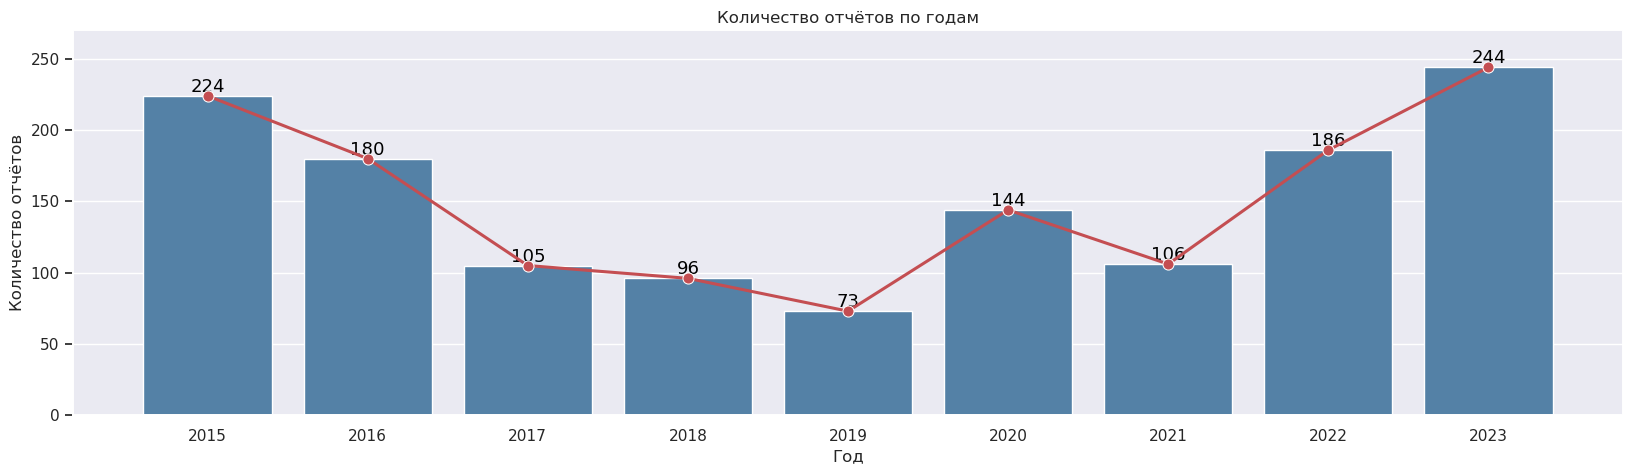

In [9]:
plt.ylim(0, 270)
ax = sns.barplot(g_by_year, x="year", y="bugs", color="steelblue")
ax.set_title('Количество отчётов по годам')
ax.set(xlabel='Год', ylabel='Количество отчётов')
ax.bar_label(ax.containers[0], fontsize=13, color="black")
ax2 = ax.twinx()
plt.ylim(0, 270)
sns.lineplot(x=g_by_year.index, y='bugs', data=g_by_year, marker='o', markersize=8, color='r', sort=False, linewidth=2.2, ax=ax2)
ax2.grid(False)
ax2.set(xlabel=None, ylabel=None)
ax2.set(yticklabels=[])
ax2.tick_params(right=None)

In [10]:
# group by months

In [11]:
g_by_date = df.groupby("date").size().reset_index(name='bugs')

In [12]:
# Добавление месяцев, в которых было 0 багов
dates = set(g_by_date["date"])

for year in range(2015, 2023 + 1):
    for month in range(1, 12 + 1):
        
        date = f"{year}.{month:0>2}"
        if date not in dates:
            g_by_date.loc[len(g_by_date)] = [date, 0]

g_by_date = g_by_date.sort_values(by="date")

In [13]:
g_by_date["year"] = g_by_date["date"].str[:-3]
g_by_date["month"] = g_by_date["date"].str[-2:]

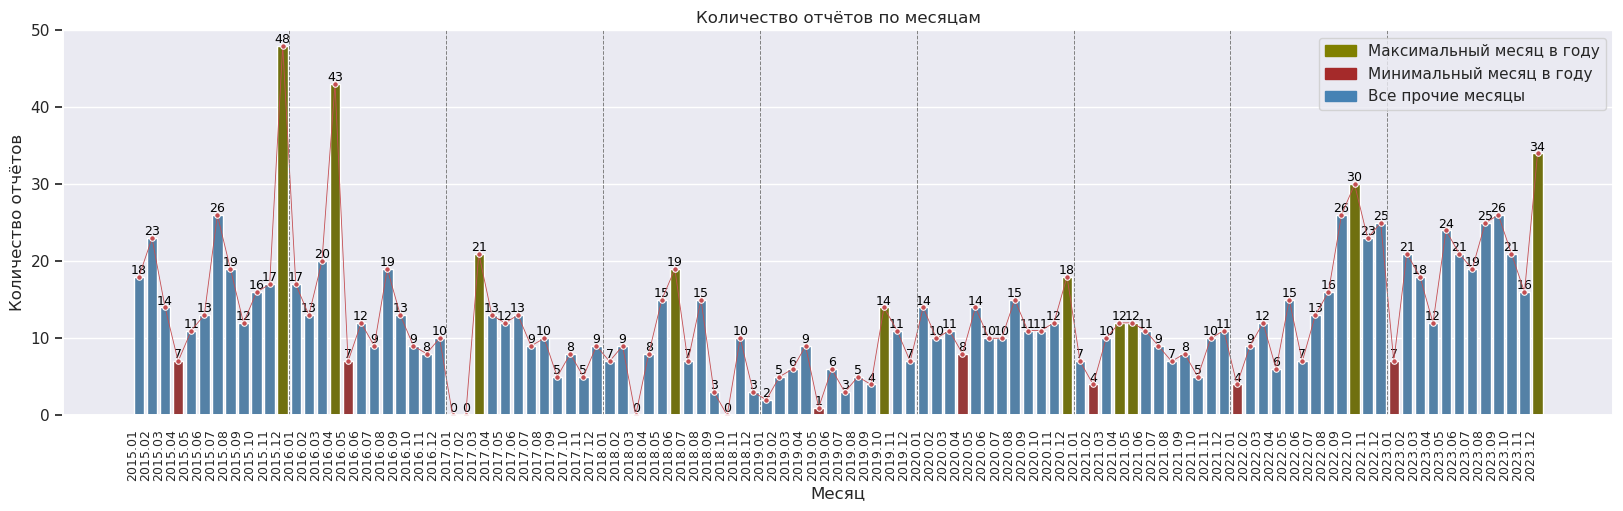

In [14]:
max_months_mask = g_by_date.groupby("year")["bugs"].transform(max) == g_by_date["bugs"]
max_month_list = g_by_date[max_months_mask]["date"].tolist()

min_months_mask = g_by_date.groupby("year")["bugs"].transform(min) == g_by_date["bugs"]
min_month_list = g_by_date[min_months_mask]["date"].tolist()

cols = []
for m in g_by_date["date"]:
    if m in max_month_list:
        cols.append("olive")
    elif m in min_month_list:
        cols.append("brown")
    else:
        cols.append("steelblue")

plt.ylim(0, 50)
plt.xticks(rotation=90, ha="right", fontsize=9)
ax = sns.barplot(g_by_date, x="date", y="bugs", palette=cols)
ax.set_title('Количество отчётов по месяцам')
ax.set(xlabel='Месяц', ylabel='Количество отчётов')
ax.bar_label(ax.containers[0], fontsize=9, color="black")
ax2 = ax.twinx()
plt.ylim(0, 50)
sns.lineplot(x='date', y='bugs', data=g_by_date, marker='o', markersize=4, color='r', sort=False, linewidth=0.6, ax=ax2)
ax2.grid(False)
ax2.set(xlabel=None, ylabel=None)
ax2.set(yticklabels=[])
ax2.tick_params(right=None)

olive = mpatches.Patch(color='olive', label='Максимальный месяц в году')
brown = mpatches.Patch(color='brown', label='Минимальный месяц в году')
blue = mpatches.Patch(color='steelblue', label='Все прочие месяцы')
plt.legend(handles=[olive, brown, blue], loc='upper right') 

plt.axvline(x=11.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=23.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=35.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=47.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=59.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=71.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=83.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=95.5, color='gray', linestyle='--', linewidth=0.7);

In [15]:
# group by quartal

In [16]:
df["quartal"] = 1
df.loc[df["month"].isin([4, 5, 6]), "quartal"] = 2
df.loc[df["month"].isin([7, 8, 9]), "quartal"] = 3
df.loc[df["month"].isin([10, 11, 12]), "quartal"] = 4

In [17]:
g_by_q = df.groupby(["year", "quartal"]).size().reset_index(name='bugs')

In [18]:
g_by_q["year_quartal"] = g_by_q["year"].astype(str) + "-Q" + g_by_q["quartal"].astype(str)

Это уже интереснее, можно попробовать обобщить данные побольше и сгруппировать количество багов по кварталм года. Да, на графике ниже уже можно чётко заметить, что больше всего багов находят во втором и четвёртом кватралах.

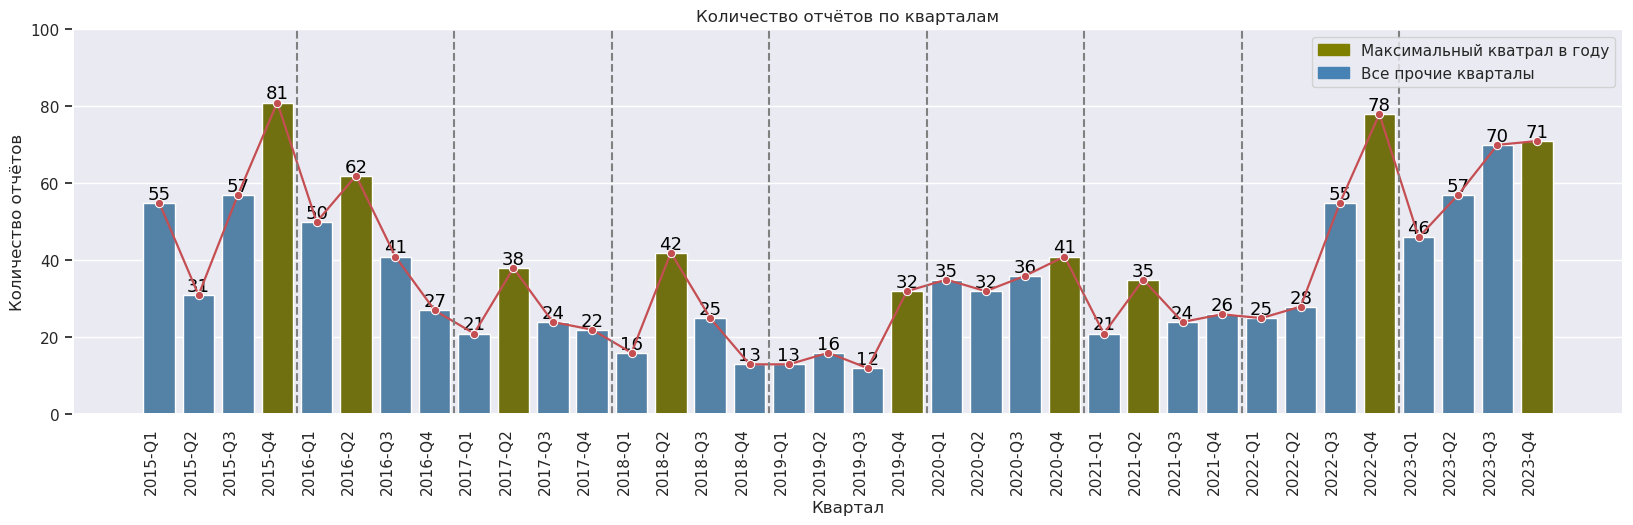

In [19]:
max_quartal_mask = g_by_q.groupby("year")["bugs"].transform(max) == g_by_q["bugs"]
max_quartal_list = g_by_q[max_quartal_mask]["year_quartal"].tolist()
cols = ['olive' if x in max_quartal_list else 'steelblue' for x in g_by_q["year_quartal"]]

plt.xticks(rotation=90, ha="right")
plt.ylim(0, 100)
ax = sns.barplot(g_by_q, x="year_quartal", y="bugs", palette=cols)
ax.set_title('Количество отчётов по кварталам')
ax.set(xlabel='Квартал', ylabel='Количество отчётов')
ax.bar_label(ax.containers[0], fontsize=13, color="black")
ax2 = ax.twinx()
plt.ylim(0, 100)
sns.lineplot(x=g_by_q.index, y='bugs', data=g_by_q, marker='o', color='r', sort=False, linewidth=1.6, ax=ax2)
ax2.grid(False)
ax2.set(xlabel=None, ylabel=None)
ax2.set(yticklabels=[])
ax2.tick_params(right=None)

olive = mpatches.Patch(color='olive', label='Максимальный кватрал в году')
blue = mpatches.Patch(color='steelblue', label='Все прочие кварталы')
plt.legend(handles=[olive, blue], loc='upper right') 

plt.axvline(x=3.5, color='gray', linestyle='--')
plt.axvline(x=7.5, color='gray', linestyle='--')
plt.axvline(x=11.5, color='gray', linestyle='--')
plt.axvline(x=15.5, color='gray', linestyle='--')
plt.axvline(x=19.5, color='gray', linestyle='--')
plt.axvline(x=23.5, color='gray', linestyle='--')
plt.axvline(x=27.5, color='gray', linestyle='--')
plt.axvline(x=31.5, color='gray', linestyle='--');

In [20]:
# Исследование и выводы

In [21]:
# У каждого квартала можно однозначно определить максимум
g_by_q.groupby("year").apply(lambda x: x["bugs"].unique().size).reset_index(name="unique_bugs_in_quartal")

,year,unique_bugs_in_quartal
0,2015,4
1,2016,4
2,2017,4
3,2018,4
4,2019,4
5,2020,4
6,2021,4
7,2022,4
8,2023,4


In [22]:
max_quartal_mask = g_by_q.groupby("year")["bugs"].transform(max) == g_by_q["bugs"]
max_quartal = g_by_q[max_quartal_mask]
max_quartal

,year,quartal,bugs,year_quartal
3,2015,4,81,2015-Q4
5,2016,2,62,2016-Q2
9,2017,2,38,2017-Q2
13,2018,2,42,2018-Q2
19,2019,4,32,2019-Q4
23,2020,4,41,2020-Q4
25,2021,2,35,2021-Q2
31,2022,4,78,2022-Q4
35,2023,4,71,2023-Q4


Действительно, за все 9 лет, что попали в исследование, максимумы были всегда в 4 и 2 кварталах. Можно предположить, что в первом квартале года выводят какую-нибудь фичу, во втором уже фиксят баги, не без помощи хантеров. В четвёром квартале года обычно спешат закрыть проекты, отсюда и количество ошибок.

In [23]:
# Максимальное кол-во баков по кварталам
max_quartal["quartal"].value_counts().reset_index(name="count quartals")

,quartal,count quartals
0,4,5
1,2,4


In [24]:
# Максимальное по месяцу (в некторых годах есть два максимума)
g_by_date["year"] = g_by_date["date"].str[:-3]
g_by_date["month"] = g_by_date["date"].str[-2:]

In [25]:
max_months_mask = g_by_date.groupby("year")["bugs"].transform(max) == g_by_date["bugs"]
max_month = g_by_date[max_months_mask]
max_month

,date,bugs,year,month
11,2015.12,48,2015,12
15,2016.04,43,2016,04
24,2017.03,21,2017,03
38,2018.06,19,2018,06
53,2019.10,14,2019,10
67,2020.12,18,2020,12
71,2021.04,12,2021,04
72,2021.05,12,2021,05
89,2022.10,30,2022,10
103,2023.12,34,2023,12


Раз уж стало ясно, в каком квартале года больше всего шансов найти баг, то можно заодно и попробовать выбрать месяц с максимальым количеством ошибок за год и подсчитать, какие месяцы чаще всего становились максимумом. Ну тут ничего удивительного, что первые три в топе месяца входят во второй и четвёртый кварталы, а именно, больше всего шансов найти баг в декабре, апреле и октябре.

In [26]:
max_month["month"].value_counts().reset_index(name="count_max_months")

,month,count_max_months
0,12,3
1,04,2
2,10,2
3,03,1
4,06,1
5,05,1


Ну раз такое дело, то можно посотреть, в каких месяцах исторически меньше всего находили багов.

In [27]:
# Минимальное по месяцу (в некторых годах есть два минимума)
min_months_mask = g_by_date.groupby("year")["bugs"].transform(min) == g_by_date["bugs"]
min_month = g_by_date[min_months_mask]
min_month

,date,bugs,year,month
3,2015.04,7,2015,04
16,2016.05,7,2016,05
104,2017.01,0,2017,01
105,2017.02,0,2017,02
106,2018.03,0,2018,03
107,2018.10,0,2018,10
48,2019.05,1,2019,05
59,2020.04,8,2020,04
69,2021.02,4,2021,02
80,2022.01,4,2022,01


Январь самый худший месяц, далее следуют апрель и май

In [28]:
min_month["month"].value_counts().reset_index(name="count_min_months")

,month,count_min_months
0,01,3
1,04,2
2,05,2
3,02,2
4,03,1
5,10,1


Апрель входит и в максимум и в минимум, однако однозначно можно сказать, что в начале года меньше шансов найти баг, январь-худший месяц, а вот в коце года вероятность обнаружения увеличивается, декабрь-самый лучший. Ну это все и так знали, ясное дело, уверен, в комментах так и скажут :)

In [29]:
# рейтинг хантеров

И вот пришло время рассмотреть подробнее хантеров.

In [30]:
df_all_hanters = df_orig[["account_link", "name", "avatar_link"]].drop_duplicates("account_link" , keep='first')
len(df_all_hanters)

542

За рассмотренный период с 2014 по 2024 года включительно в программе поучаствовало 542 хантера, думаю тут можно пренебреч тем, что кто-то зачем-то регистировал баги с разных аккаунтов. В общем можно точно сказать, что уж овер 500 уникальных хантеров точно есть.

In [31]:
df_top_hanters = df_orig["account_link"].value_counts().head(10).reset_index(name="count_bugs")
df_top_hanters = pd.merge(df_top_hanters, df_all_hanters, on='account_link')

Из них, если рассмотреть топ 10 появляются просто удивительные люди, хантер с первого места нашёл аж 50 багов (хотя как мы [знаем](https://habr.com/ru/articles/749452/) яндекс далеко не всегда за них платит).

In [32]:
df_top_hanters[["name", "account_link", "count_bugs", "avatar_link"]]

,name,account_link,count_bugs,avatar_link
0,Сергей,https://reviews.yandex.ru/user/u793wbwtmp98bah...,51,https://avatars.mds.yandex.net/get-yapic/21493...
1,nn9899,https://reviews.yandex.ru/user/19f225m8ud9huzq...,38,https://avatars.mds.yandex.net/get-yapic/39803...
2,Deepak Kivande,https://reviews.yandex.ru/user/c0pawaktxzueky6...,38,https://avatars.mds.yandex.net/get-yapic/25358...
3,pyrk1,https://reviews.yandex.ru/user/m69nzkbcvcnt6km...,31,https://avatars.mds.yandex.net/get-yapic/0/0-0...
4,amlnspqr,https://reviews.yandex.ru/user/ggbndn8tvvy6urt...,30,https://avatars.mds.yandex.net/get-yapic/38135...
5,Thomas Anderson,https://reviews.yandex.ru/user/6fn89bv4zbu3wk2...,28,https://avatars.mds.yandex.net/get-yapic/0/0-0...
6,fle_xxx,https://reviews.yandex.ru/user/flexxx73,24,https://avatars.mds.yandex.net/get-yapic/26057...
7,xsstestov,https://reviews.yandex.ru/user/00uxuwdz3ejt8ca...,22,https://avatars.mds.yandex.net/get-yapic/51169...
8,h3llwish,https://reviews.yandex.ru/user/0w5f7642kz8qfmc...,22,https://avatars.mds.yandex.net/get-yapic/0/0-0...
9,Karim Valiev,https://reviews.yandex.ru/user/jb27uy8qf3d6ec6...,22,https://avatars.mds.yandex.net/get-yapic/0/0-0...


Это кончено просто удвительно, на текущий момент из рассмотренных 113 месяцев программы топ хантер нашёл 50 ошибок, т.е. другими словами можно сказать, что он находит один баг за два месяца. Точно можно скзать одно, как работают шестерёнки топовых хантеров это просто нечто, я еле-еле нашёл один баг, думаю меня и в зал славы добавлии, потому-что был надоедливым и таким образом решили отмахнуться как от назойливаой мухи, а тут кто-то аж 50 багов отыскал!

In [33]:
data_list = []
df_all = df_orig.copy()
for year in range(2024, 2014 - 1, -1):
    for month in range(12, 1 - 1, -1):

        # Ограничение на начало
        if year == 2014 and month < 12:
            continue

        # Ограничение на конец
        if year == 2024 and month > 3:
            continue

        date = f"{year}.{month:0>2}"
        
        curr = df_all[df_all["date"] == date]
        df_all = df_all[df_all["date"] != date]

        newbie = curr[~curr["account_link"].isin(df_all["account_link"])]

        data_list.append(
            {
                "date": date,
                "all_hunters": len(curr),
                "newbie": len(newbie),
            }
        )

data_list.append(
    {
        "date": "2014.11",
        "all_hunters": len(df_all),
        "newbie": len(df_all),
    }
)
        
df_newbie = pd.DataFrame(data_list)
df_newbie = df_newbie.sort_values(by="date")

Вспоминая про свою мотивацию искать баги, я кончено думал, что было бы неплохо перевоплатиться из Томаса А. Андерсона в Нео. Да вот только волшебной красной таблетки не существует, придётся упорно и много работать, такого в кино точно не покажут. Но ведь каждый месяц, как я верно прикинул в прошлой своей статье в зале славы появляется около десятка новых лиц, теперь можно это оценить точно на графике ниже.

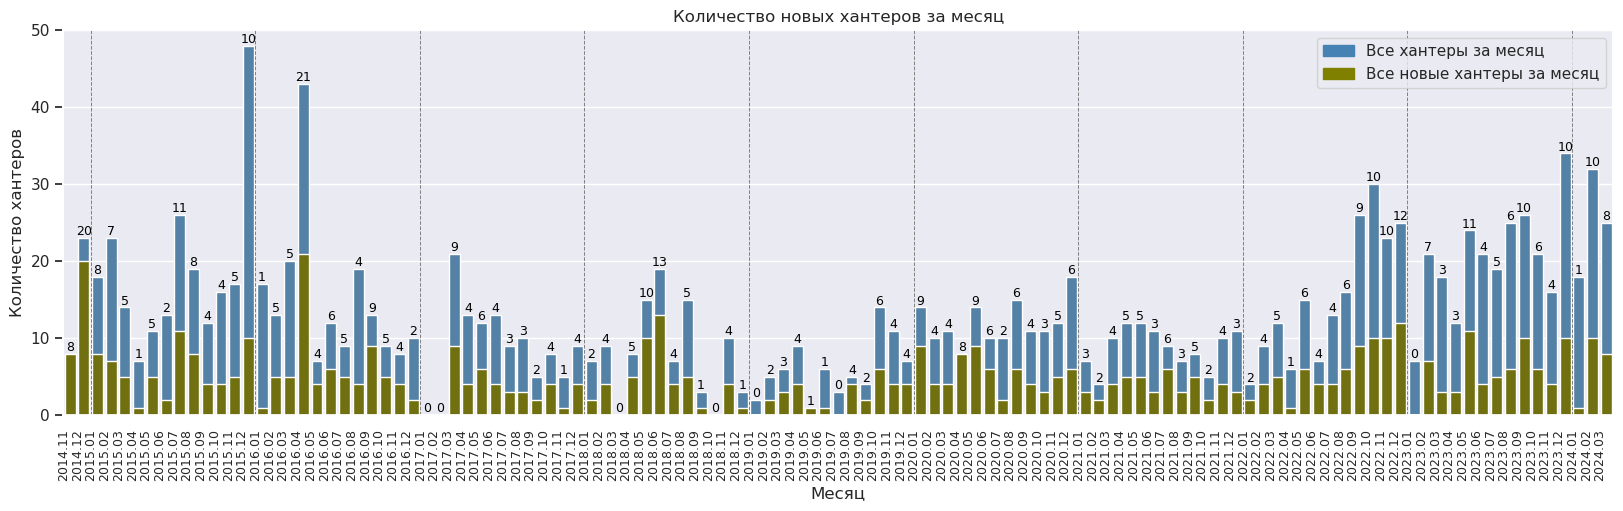

In [34]:
plt.xticks(rotation=90, ha="right", fontsize=9)
plt.ylim(0, 50)
ax = sns.barplot(df_newbie, x="date", y="all_hunters", color="steelblue")
ax.set_title('Количество новых хантеров за месяц')
ax.set(xlabel='Месяц', ylabel='Количество хантеров')
ax.bar_label(ax.containers[0], labels=df_newbie["newbie"], fontsize=9, color="black")

ax2 = ax.twinx()
plt.ylim(0, 50)
sns.barplot(df_newbie, x="date", y="newbie", color="olive", ax=ax2)
ax2.grid(False)
ax2.set(xlabel=None, ylabel=None)
ax2.set(yticklabels=[])
ax2.tick_params(right=None)

blue = mpatches.Patch(color='steelblue', label='Все хантеры за месяц')
olive = mpatches.Patch(color='olive', label='Все новые хантеры за месяц')
plt.legend(handles=[blue, olive], loc='upper right') 

plt.axvline(x=1.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=13.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=25.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=37.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=49.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=61.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=73.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=85.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=97.5, color='gray', linestyle='--', linewidth=0.7)
plt.axvline(x=109.5, color='gray', linestyle='--', linewidth=0.7);

In [35]:
df_newbie["newbie"].sum() / df_newbie["all_hunters"].sum() * 100

38.31967213114754

В среднем новичков получается 38,32% от общего числа хантеров за месяц. Не думаю, что все эти люди обладают какими-то сакральными знаниями, которые доступны лишь избранным и тем более, не нужно думать, что ошибки, какие были на поверхности все до единой найдены и остались только сложные и труднонаходимые. Как верно гласит народная мудрость: “не ошибается тот, кто ничего не делает”, а Яндекс делает много и пока  выводятся новые и изменяются старые продукты, ошибки будут, осталось только их найти.

In [60]:
# for i in range(10):
#     tmp = df_top_hanters[["name", "account_link", "count_bugs", "avatar_link"]].iloc[i]
#     print(f"{i+1}. ![]({tmp.iat[3]}) [{tmp.iat[0]}]({tmp.iat[1]}) - {tmp.iat[2]}")